In [1]:
import os
import numpy as np
import zarr
from ome_zarr.io import parse_url
from ome_zarr.reader import Reader
import dask.array as da

from cellpose import models

import napari
from napari.settings import get_settings
get_settings().application.ipy_interactive = True

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [2]:
# pathway to the input data
input_path_zarr = r'R:\Kasia\tracking\TrackGardener\B4_C1_small.zarr'

# read in the data
reader = Reader(parse_url(input_path_zarr))

image_node = list(reader())[0]
dask_data = image_node.data[0]
dask_data

c:\Users\kmk280\AppData\Local\miniconda3\envs\cellpose2-env\lib\site-packages\zarr\creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


dask.array<from-zarr, shape=(241, 8400, 8396), dtype=uint16, chunksize=(10, 512, 512), chunktype=numpy.ndarray>

In [3]:
# specify if all frame is to be segmented (start 0 and stop -1 for the full movie)
params = {
    'frame_start': -30,
    'row_start': 3000,
    'col_start': 3000,
    'frame_stop': -1,
    'row_stop': 4000,
    'col_stop': 4000
}

# check that the values are acceptable

# modify the values if they are negative
data_shapes = [dask_data.shape[0], dask_data.shape[1], dask_data.shape[2]]
params = {key: value + data_shapes[i % 3] if value < 0 else value for i, (key, value) in enumerate(params.items())}
frame_start, row_start, col_start, frame_stop, row_stop, col_stop = [params[key] for key in params]


assert frame_start < frame_stop, f'frame_start {frame_start} should be smaller than frame_stop {frame_stop}'
assert row_start < row_stop, f'row_start {row_start} should be smaller than row_stop {row_stop}'
assert col_start < col_stop, f'col_start {col_start} should be smaller than col_stop {col_stop}'

In [4]:
# read cellpose model
model_name = 'cyto2'
model = models.CellposeModel(gpu=True,model_type = model_name)

c:\Users\kmk280\AppData\Local\miniconda3\envs\cellpose2-env\lib\site-packages\cellpose\resnet_torch.py:225: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

### Segment to png files

In [5]:
masks_all = []
for i in tqdm(range(frame_start,frame_stop)):

    im_frame = dask_data[i,row_start:row_stop,col_start:col_stop]
    mask,_,_ = model.eval(im_frame,diameter = 30)

    masks_all.append(mask)

masks_all = np.array(masks_all)

  0%|          | 0/29 [00:00<?, ?it/s]

### Display to check segmentation quality

In [6]:
viewer = napari.Viewer()
viewer.add_image(dask_data[frame_start:frame_stop,row_start:row_stop,col_start:col_stop], name=model_name)
viewer.add_labels(masks_all, name='mask')
viewer.dims.current_step = (frame_start,0,0)

(-0.5, 783.5, 576.5, -0.5)

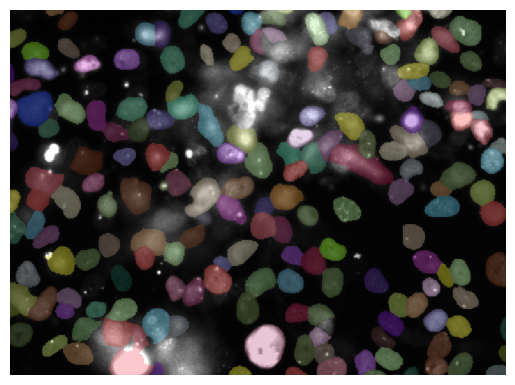

In [11]:
plt.imshow(viewer.screenshot())
plt.axis('off')